# CBU5201 miniproject advanced task



## 1 Author

**Student Name**: Chenhui Qiu

**QMID**: 210981508

## 2 Problem formulation

Since in the basic task, I have tried the classification and regression models of supervised learning in machine learning on the Genki4k dataset and used its four existing labels. Therefore, here I want to use unsupervised learning to cluster this data set, try to find its most significant features, and then perform dimensionality reduction and visualization to find its potential patterns.


## 3. Machine Learning Pipeline


1. **Data Preprocessing:**
   - **Face Detection:** Utilizing MTCNN (Multi-task Cascaded Convolutional Networks) for detecting and cropping faces from images in the dataset.
   - **Image Transformation:** Applying a series of transformations to the detected faces, including tensor conversion and normalization, to prepare them for feature extraction.

2. **Feature Extraction:**
Employing a pre-trained ResNet18 model with the last fully connected layer removed (replaced with an identity layer) to maintain the feature representations.Processing each image through it to extract a set of features, forming the basis for subsequent clustering and dimensionality reduction.

3. **Clustering:**
Implementing K-means to group the extracted features into clusters. This step is essential for identifying natural groupings in the dataset.

4. **Dimensionality Reduction:**
Using UMAP (Uniform Manifold Approximation and Projection) to reduce the dimensionality of the feature set. This step aids in visualizing the high-dimensional data in a lower-dimensional space, enhancing interpretability.

5. **Visualization:**
Creating scatter plot to visually represent the clusters. This plot provides a spatial understanding of how the data points are grouped.

6. **Sample Selection from Clusters:**
Selecting a subset of samples from each identified cluster. This procedure allows for a more detailed examination of the characteristics of each cluster.

This pipeline effectively combines face detection, deep learning-based feature extraction, clustering, and advanced visualization techniques. It serves as a comprehensive approach for analyzing and understanding complex image datasets, particularly where facial features are of interest. The use of both K-means and UMAP provides a robust method for uncovering and visualizing the inherent structures within the data.

## 4. Dataset


The primary dataset used in this project is still the "Genki4K," a comprehensive collection of facial images. This dataset is known for its diversity in facial expressions and orientations.

### Preprocessing with MTCNN

- **Why MTCNN**: MTCNN (Multi-task Cascaded Convolutional Networks) is a highly effective method for face detection, particularly adept at handling different scales of faces within images. It's chosen for its accuracy in isolating faces from complex backgrounds , which is critical for consistent model training.
- MTCNN detects facial landmarks (like eyes, nose, and mouth) and crops the faces. This step ensures that the models focus on relevant facial features without background distractions.
- After detection and cropping, the images undergo further transformations, including conversion to tensor format and normalization using standard mean and standard deviation values. 

#### Output
- The output of this preprocessing stage is a set of images, each now transformed into a cropped, tensor-format face with normalized pixel values. These processed images form the foundation for subsequent model training and validation, providing a consistent and focused dataset for the neural networks to learn from.



In [11]:
import os
import torch
from tqdm import tqdm
from PIL import Image
from facenet_pytorch import MTCNN
from torchvision import models, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MTCNN for face detection
mtcnn = MTCNN(keep_all=False, device=device, image_size=128, margin=30)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_data(img_dir, mtcnn, transform):
    processed_images = []
    for img_file in tqdm(os.listdir(img_dir)):
        img_path = os.path.join(img_dir, img_file)
        img = Image.open(img_path).convert('RGB')
        img_cropped = mtcnn(img)
        if img_cropped is not None:
            if not isinstance(img_cropped, torch.Tensor):
                img_cropped = transform(img_cropped)
            processed_images.append(img_cropped)
    return torch.stack(processed_images)

## 5. Transformation Stage

In this phase, we transform the pre-processed face images into a format that is optimal for training deep learning models. 

#### Input
- The input consists of pre-processed face images, which have been cropped and adjusted using MTCNN. These images are now ready to undergo further transformation to extract meaningful features.

#### Feature Extraction
- The primary objective here is to extract features from these processed images. This is achieved by passing each image through a neural network model, which acts as a feature extractor. 
- The process leverages the power of deep learning models to transform raw pixel data into a higher-level representation. This transformation is crucial for capturing complex patterns and characteristics in the images, which are essential for tasks such as smile detection and head pose estimation.

#### Output
- The output of this stage is a set of features, represented as arrays in NumPy format. These features encapsulate critical information from the images, ready to be utilized in the subsequent stages of model training and analysis.



In [12]:
import numpy as np

def extract_features(processed_images, model):
    features = []
    with torch.no_grad():
        for img in tqdm(processed_images):
            feature = model(img.unsqueeze(0).to(device))
            features.append(feature.cpu().numpy().squeeze())
    return np.array(features)


## 6. Modelling

In our project, we utilize the ResNet-18 model, a widely acclaimed deep convolutional neural network, known for its efficient balance between computational demand and performance in image processing tasks. 

It with its deep convolutional layers and pre-training on the vast ImageNet dataset, excels in extracting intricate and nuanced features from images, thereby providing a robust foundation for accurate image analysis. 


In [13]:
from torchvision.models import ResNet18_Weights
# Load a pre-trained ResNet model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Identity()  # Removing the last fully connected layer
model = model.to(device)


## 7. Methodology

#### Clustering with K-Means

- **K-Means Clustering**: Out of several clustering methods evaluated, K-Means was chosen for its simplicity and effectiveness in grouping data into coherent clusters. This method aids in identifying inherent groupings within the features.We apply K-Means clustering to the reduced-dimensional data. 

#### Dimensionality Reduction with UMAP

- **UMAP (Uniform Manifold Approximation and Projection)**: After testing various dimensionality reduction techniques, UMAP was selected for its exceptional performance in preserving both the local and global structure of high-dimensional data. We optimize UMAP's parameters like `n_neighbors` and `min_dist` to balance between local and broader data structures.



In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap

def umap_dimension_reduction(features, n_components=2, n_neighbors=15, min_dist=0.1):
   
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist)
    reduced_features = reducer.fit_transform(scaled_features)
    return reduced_features

def perform_clustering(features, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(features)
    return labels


## 8. Results


In our process, we used K-means clustering on a dataset with two different cluster counts, $ K = 2 $, $K=3$ and $ K = 4 $, to explore inherent groupings within the data. Following the clustering, we applied UMAP for dimensionality reduction, visualizing the results in both two and three dimensions. This approach allowed us to observe the clustering patterns clearly and understand the spatial relationships among the data points. We also selected representative samples from each cluster for further examination. 


100%|██████████| 3992/3992 [00:09<00:00, 400.21it/s]
C:\Users\1\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\1\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\1\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


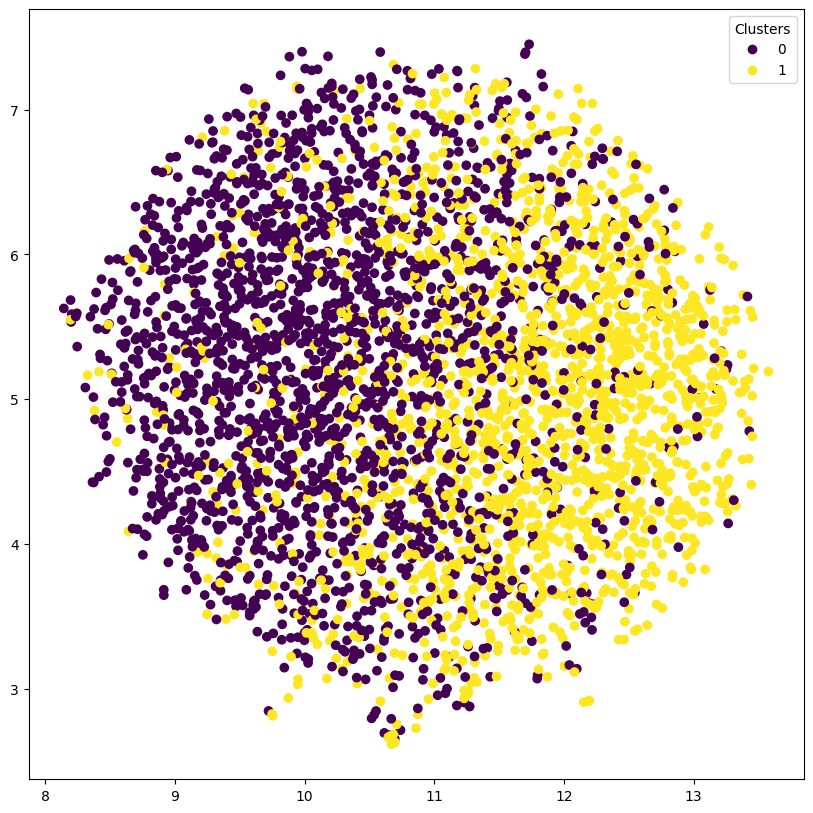

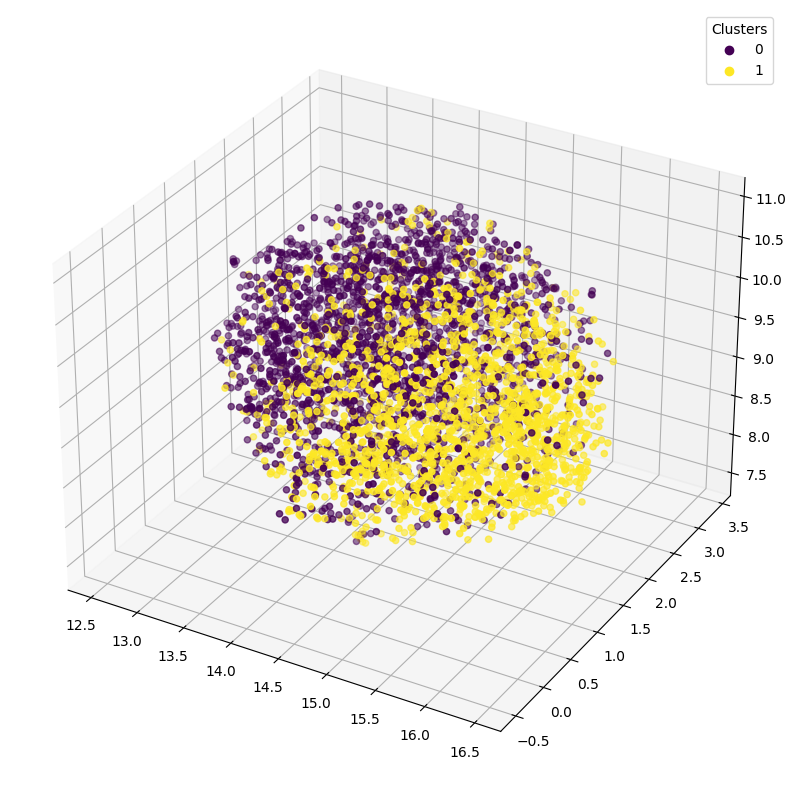

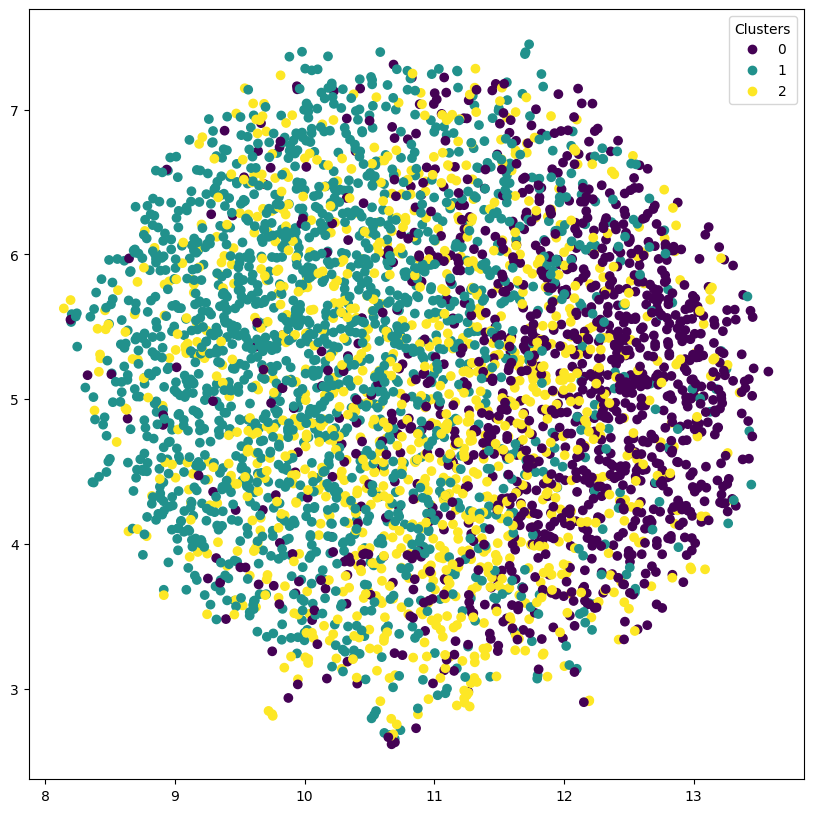

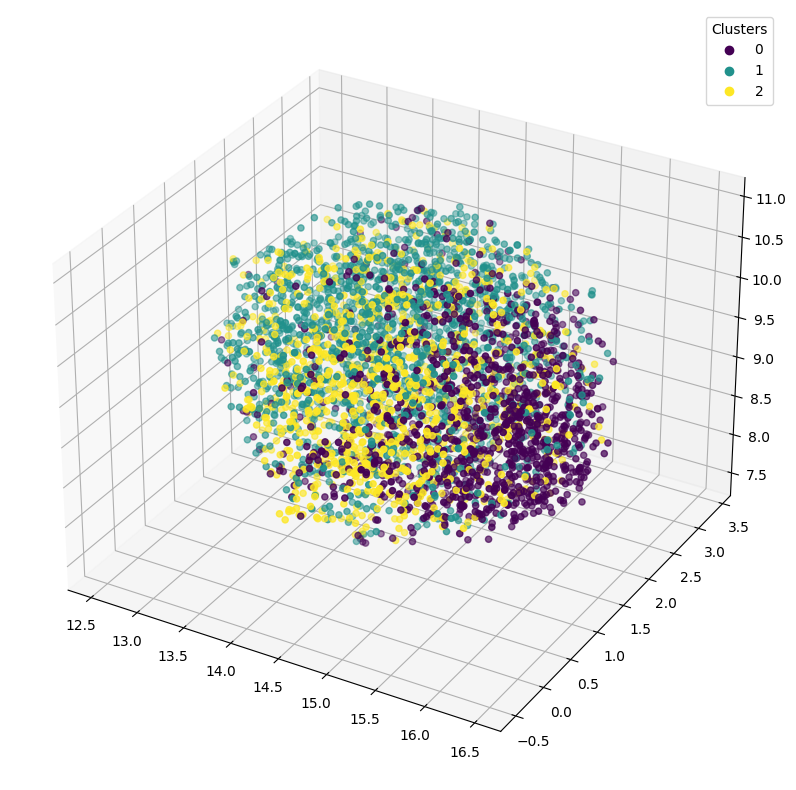

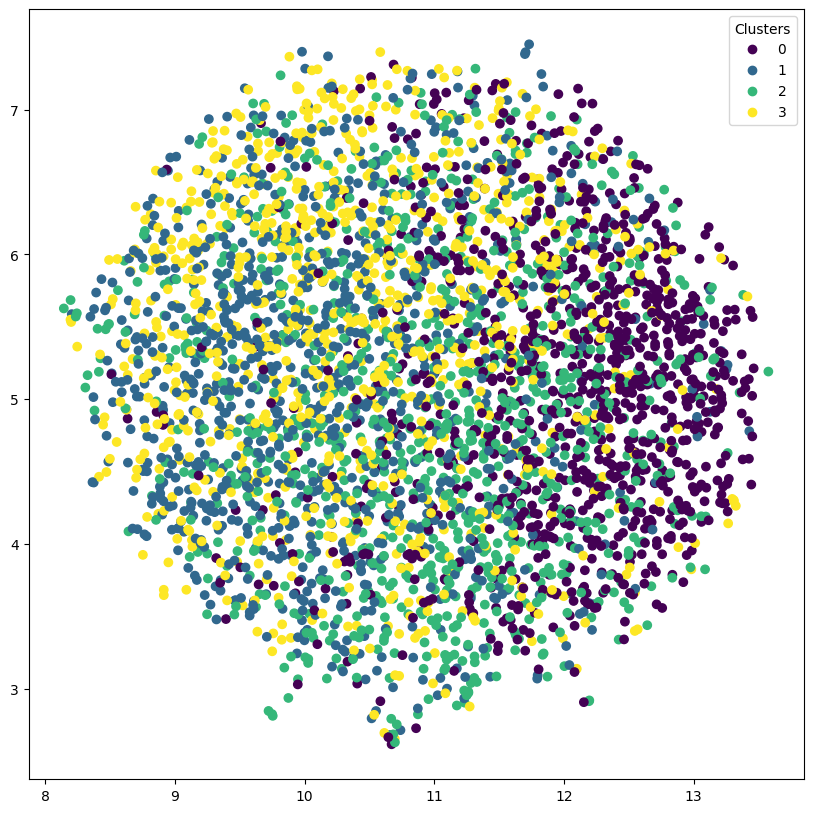

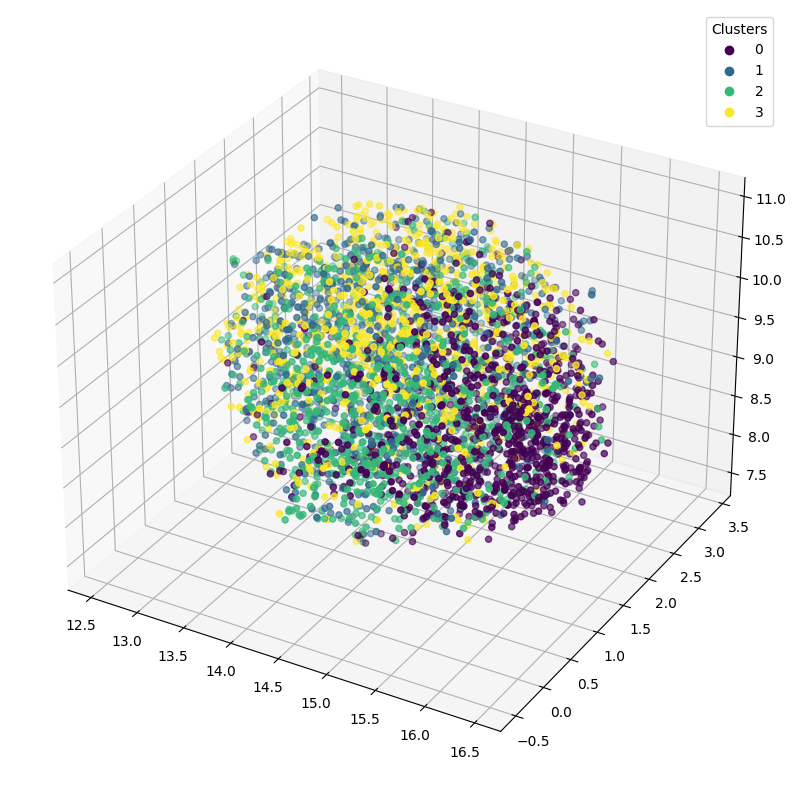

选取的样本已保存到 clustered_samples 2 class
选取的样本已保存到 clustered_samples 3 class
选取的样本已保存到 clustered_samples 4 class


In [15]:
import matplotlib.pyplot as plt
import shutil


def visualize_clusters_3d(data, labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='viridis', depthshade=True)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()

def visualize_clusters(data, labels):
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()

def select_samples_from_clusters(labels, img_dir, samples_per_cluster=10, output_dir='clustered_samples'):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for cluster_id in np.unique(labels):
        if cluster_id == -1:
            continue  
        
        cluster_dir = os.path.join(output_dir, f'cluster_{cluster_id}')
        os.makedirs(cluster_dir, exist_ok=True)

        cluster_indices = np.where(labels == cluster_id)[0]

        selected_indices = np.random.choice(cluster_indices, samples_per_cluster, replace=False)

        for idx in selected_indices:
            img_file = os.listdir(img_dir)[idx]

            src_img_path = os.path.join(img_dir, img_file)

            dst_img_path = os.path.join(cluster_dir, img_file)

            shutil.copy(src_img_path, dst_img_path)

    print(f"选取的样本已保存到 {output_dir}")


# Replace with your dataset directory
img_dir = 'genki4k\\files'

# Data Preprocessing
processed_images = preprocess_data(img_dir, mtcnn, transform)

# processed_images = preprocess_data_without_mtcnn(img_dir, transform)

# Feature Extraction
features = extract_features(processed_images, model)


# Clustering
labels = perform_clustering(features)
labels2 = perform_clustering(features,3)
labels3 = perform_clustering(features,4)
# labels = perform_hdbscan_clustering(features)

# Dimension Reduction per Cluster
# reduced_data, new_labels = dimension_reduction_per_cluster(features, labels)

# dimension reduced
reduced_data1 = umap_dimension_reduction(features, n_components=3)
reduced_data2 = umap_dimension_reduction(features, n_components=2)
# Visualization

visualize_clusters(reduced_data2, labels)
visualize_clusters_3d(reduced_data1, labels)

visualize_clusters(reduced_data2, labels2)
visualize_clusters_3d(reduced_data1, labels2)

visualize_clusters(reduced_data2, labels3)
visualize_clusters_3d(reduced_data1, labels3)





# Select samples from clusters
# select_samples_from_clusters(new_labels, img_dir, 15, output_dir='clustered_samples')
select_samples_from_clusters(labels, img_dir, 15, output_dir='clustered_samples 2 class')
select_samples_from_clusters(labels2, img_dir, 15, output_dir='clustered_samples 3 class')
select_samples_from_clusters(labels3, img_dir, 15, output_dir='clustered_samples 4 class')

Upon visual examination of the 2D and 3D visualizations, we observed that clustering the data into two groups (K = 2) yielded a more distinct and interpretable separation. Notably, the two primary categories that emerged were individuals smiling and those not smiling. This clear dichotomy in facial expressions was evident from the analysis of 15 representative images from each cluster, underscoring the effectiveness of the chosen methodology in distinguishing between these two emotive states.

However, when the data was clustered into three (K = 3) and four (K = 4) groups, the distinctions between the clusters became less clear. The visualizations did not reveal any strikingly different characteristics, and the examination of sample images from these clusters did not present any readily identifiable features that could be used to differentiate between the groups. This suggests that increasing the number of clusters beyond two did not contribute to a more nuanced understanding of the dataset in this particular context.


## 9. Conclusions

From the results of our analysis on this dataset, following the procedures and treatments applied, it can be preliminarily concluded that the most prominent feature differentiation lies in the binary classification of smiling versus non-smiling expressions. This clear demarcation is likely attributed to a balanced distribution of samples within the dataset, which facilitated a distinct separation. Additionally, we experimented with dimensionality reduction prior to clustering, but this approach yielded subpar results and was thus not emphasized in our process.

To further improve and refine our analysis, exploring a wider variety of preprocessing techniques could be beneficial for distinguishing different features more effectively. Moreover, there might be other clustering and dimensionality reduction methods that we have not yet explored, which could potentially offer more intuitive and in-depth extraction of other feature differences and aid in more detailed visualization and classification.

In future endeavors, it would be advantageous to experiment with advanced machine learning models and algorithms to enhance the accuracy and depth of our analysis. The incorporation of additional data points or more diverse datasets could also provide a broader perspective and aid in generalizing our findings. This study serves as a stepping stone in understanding facial expressions through data analysis, and further research could expand on these insights to cover a broader spectrum of human emotions and interactions.